# extract zip file and load the dataset

In [63]:
# extract zip file and load the dataset
import zipfile
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
input_path = Path(r"C:\Users\soft\Downloads\Sample - Superstore.csv.zip")
data_dir = Path.cwd() / "data"
data_dir.mkdir(exist_ok=True)
if input_path.suffix.lower() == ".zip":
    with zipfile.ZipFile(input_path, "r") as z:
        # find first .csv file in zip
        csv_files = [f for f in z.namelist() if f.lower().endswith(".csv")]
        if len(csv_files) == 0:
            raise FileNotFoundError("No CSV found inside the zip archive.")
        csv_name = csv_files[0]
        z.extract(csv_name, path=data_dir)
        csv_path = data_dir / csv_name
else:
    csv_path = input_path

print("Reading:", csv_path)
df = pd.read_csv(csv_path, encoding='latin1')
print("Raw rows:", len(df))
df.head()


Reading: C:\Users\soft\data\Sample - Superstore.csv
Raw rows: 9994


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


#  Data Cleaning and Aggregation 

In [66]:
# Imports  essential libraries 
import zipfile
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance
input_path = Path(r"C:\Users\soft\Downloads\Sample - Superstore.csv.zip") 
data_dir = Path.cwd() / "data"
data_dir.mkdir(exist_ok=True)

if input_path.suffix.lower() == ".zip":
    with zipfile.ZipFile(input_path, "r") as z:
        csv_files = [f for f in z.namelist() if f.lower().endswith(".csv")]
        if not csv_files:
            raise FileNotFoundError("No CSV found inside the zip archive.")
        csv_name = csv_files[0]
        z.extract(csv_name, path=data_dir)
        csv_path = data_dir / csv_name
else:
    csv_path = input_path

print("Reading:", csv_path)
df = pd.read_csv(csv_path, encoding='latin1')
print("Raw rows:", len(df))

# Fix: Explicitly define the date format.
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y', errors='coerce')

# Drop rows where date conversion failed
df.dropna(subset=['Order Date'], inplace=True)
print(f"Rows after dropping failed date entries: {len(df)}")

# 3. Aggregate Sales to Daily Time Series
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales.columns = ['Date', 'Sales']

print(f"Time Series Length: {len(daily_sales)} days")
print(f"Date Range: {daily_sales['Date'].min().date()} to {daily_sales['Date'].max().date()}")

Reading: C:\Users\soft\data\Sample - Superstore.csv
Raw rows: 9994
Rows after dropping failed date entries: 9994
Time Series Length: 1237 days
Date Range: 2014-01-03 to 2017-12-30


#  Basic Statistics and Explaory data analysis (EDA)

In [69]:
print("\nBasic Sales Statistics:")
print(daily_sales['Sales'].describe().apply(lambda x: f'{x:,.2f}'))


Basic Sales Statistics:
count     1,237.00
mean      1,857.07
std       2,305.54
min           2.02
25%         377.74
50%       1,063.18
75%       2,395.79
max      28,106.72
Name: Sales, dtype: object


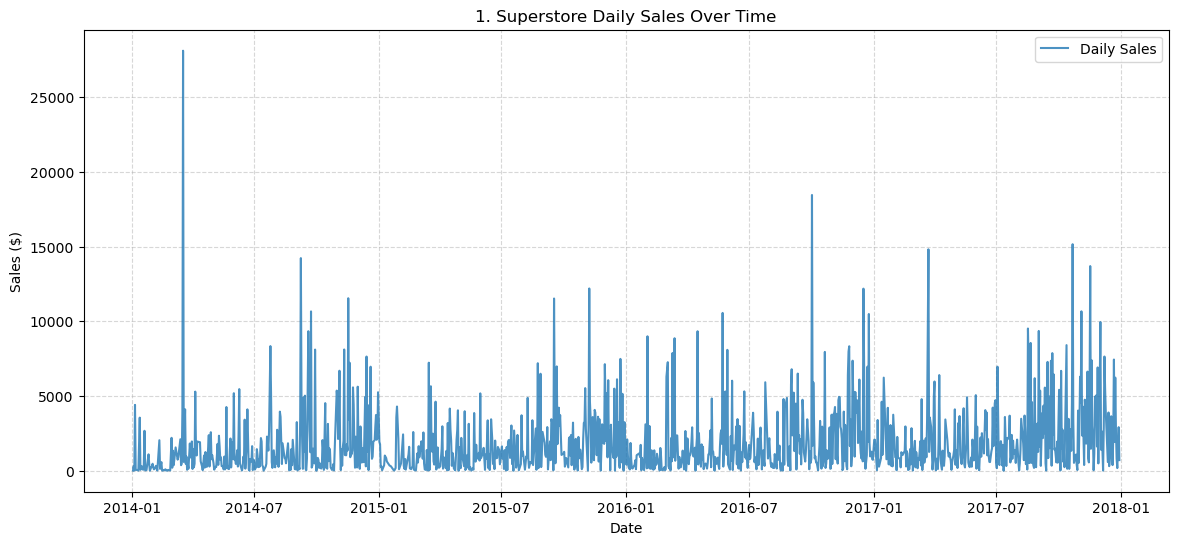

In [71]:
#  Time Series Plot (Overall Trend)
plt.figure(figsize=(14, 6))
plt.plot(daily_sales['Date'], daily_sales['Sales'], label='Daily Sales', color='tab:blue', alpha=0.8)
plt.title('1. Superstore Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

C:\Users\soft\AppData\Local\Temp\ipykernel_3664\3177928636.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = daily_sales.set_index('Date').resample('M')['Sales'].sum()


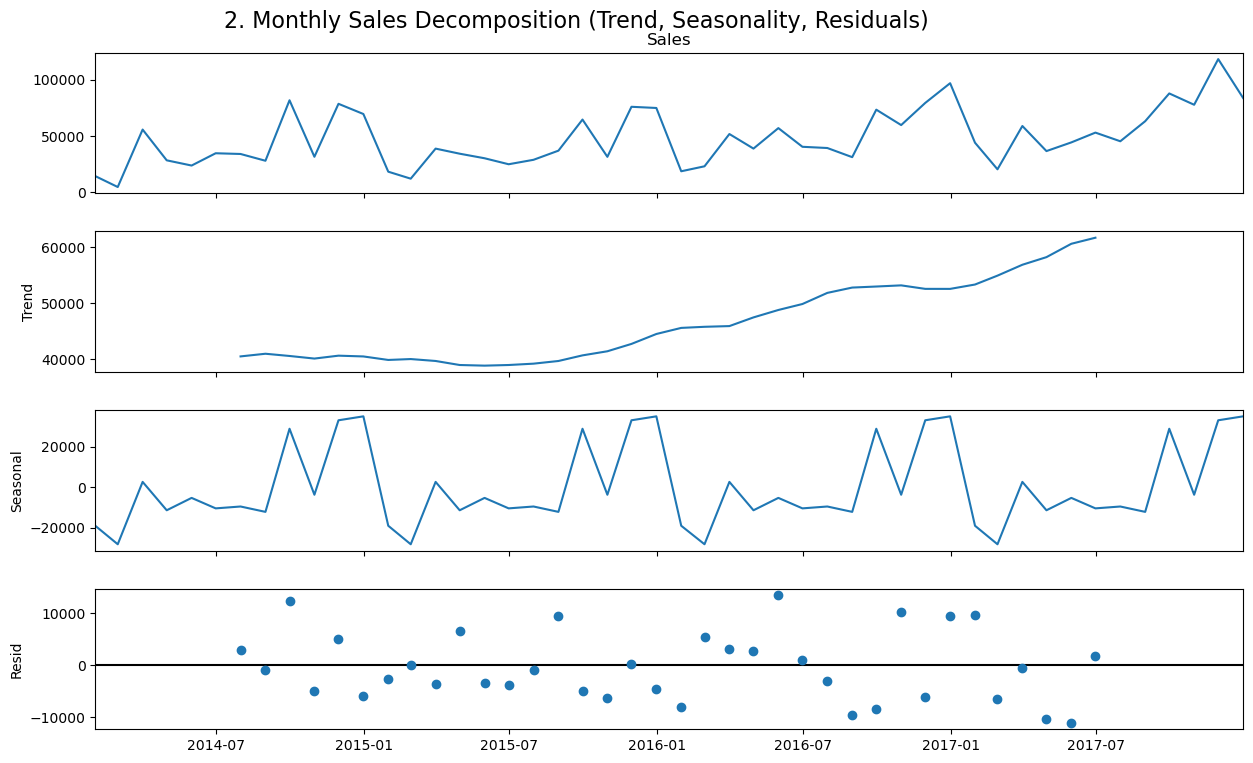

In [73]:
#trend and seasonalty
from statsmodels.tsa.seasonal import seasonal_decompose

# Resample to monthly sales for smoother decomposition
monthly_sales = daily_sales.set_index('Date').resample('M')['Sales'].sum()
decomposition = seasonal_decompose(monthly_sales, model='additive', period=12) 

fig = decomposition.plot()
fig.set_size_inches(14, 8)
fig.suptitle('2. Monthly Sales Decomposition (Trend, Seasonality, Residuals)', fontsize=16)
plt.show()

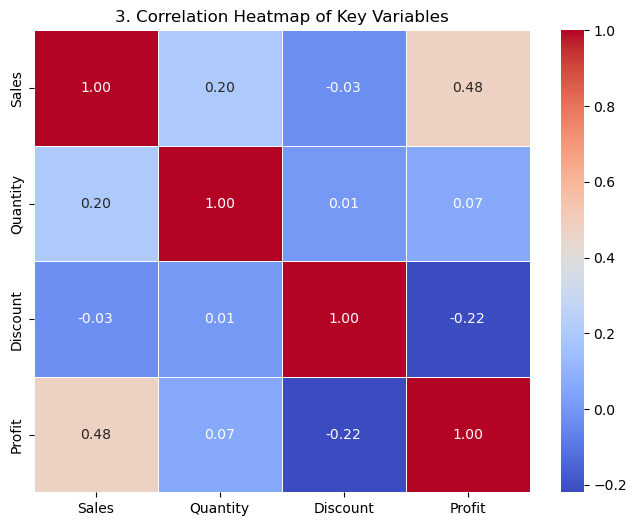

In [75]:
# Correlation Heatmap (Sales, Quantity, Profit, Discount)

numeric_cols = ['Sales', 'Quantity', 'Discount', 'Profit']
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('3. Correlation Heatmap of Key Variables')
plt.show()

#  Sales Forecasting with Prophet

In [78]:
#  Data Preparation for Prophet
prophet_df = daily_sales.rename(columns={'Date': 'ds', 'Sales': 'y'})

In [80]:
#  Train/Test Split 
test_days = 365
train_prophet = prophet_df.iloc[:-test_days]
test_prophet = prophet_df.iloc[-test_days:]

In [82]:
#  Initialize and Fit Prophet Model
model_prophet = Prophet(
    # Set yearly seasonality to True based on EDA
    yearly_seasonality=True,
    # Set weekly seasonality to True
    weekly_seasonality=True,
    daily_seasonality=False,
    interval_width=0.95
)
model_prophet.fit(train_prophet)

23:53:12 - cmdstanpy - INFO - Chain [1] start processing
23:53:14 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
# Create Future Dates and Predict
future_prophet = model_prophet.make_future_dataframe(periods=test_days + 90)
forecast_prophet = model_prophet.predict(future_prophet)

In [86]:
#Extract Predictions for the Test Period
prophet_predictions = forecast_prophet.tail(test_days + 90).head(test_days)
prophet_predictions_test = prophet_predictions['yhat']

In [88]:
# Evaluation Metrics (on the test set)
prophet_rmse = np.sqrt(mean_squared_error(test_prophet['y'], prophet_predictions_test))
prophet_mae = mean_absolute_error(test_prophet['y'], prophet_predictions_test)

print(f"Prophet Test RMSE: ${prophet_rmse:,.2f}")
print(f"Prophet Test MAE: ${prophet_mae:,.2f}")

Prophet Test RMSE: $2,612.60
Prophet Test MAE: $1,795.34


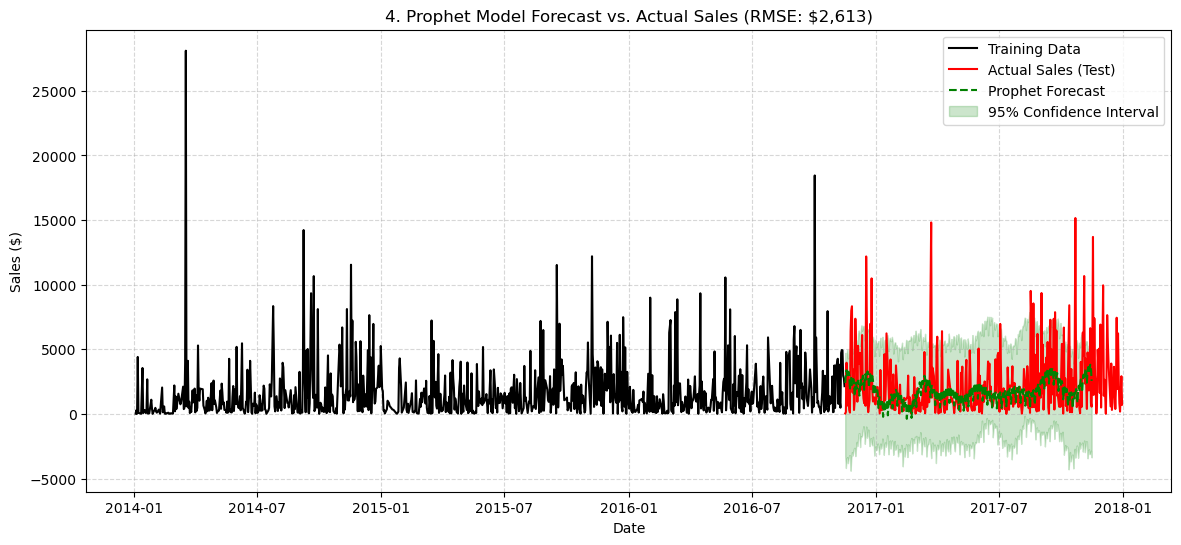

In [90]:
#  Plot Real and Forecast Sales
plt.figure(figsize=(14, 6))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Training Data', color='black')
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual Sales (Test)', color='red')
plt.plot(prophet_predictions['ds'], prophet_predictions['yhat'], label='Prophet Forecast', color='green', linestyle='--')
plt.fill_between(prophet_predictions['ds'], forecast_prophet['yhat_lower'].iloc[-test_days:], forecast_prophet['yhat_upper'].iloc[-test_days:], color='green', alpha=0.2, label='95% Confidence Interval')
plt.title(f'4. Prophet Model Forecast vs. Actual Sales (RMSE: ${prophet_rmse:,.0f})')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

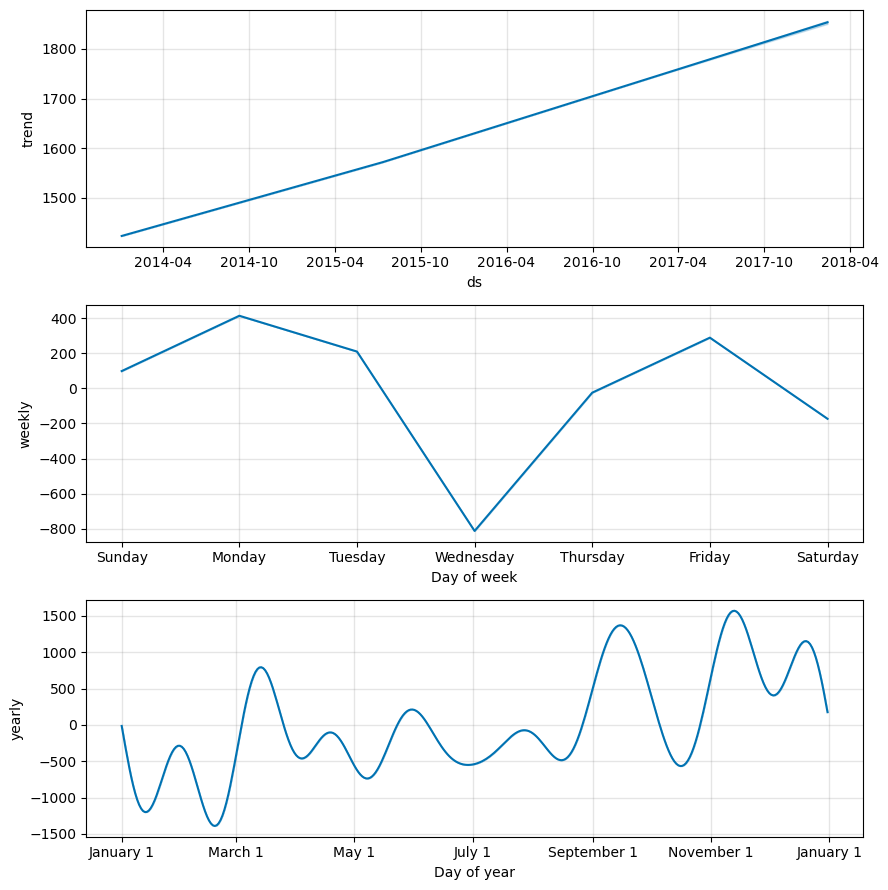

In [91]:
#Plot Prophet Components
fig_comp = model_prophet.plot_components(forecast_prophet)
plt.show()

#  Sales Forecasting with XGBoost Regression

In [95]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Feature Engineering 
xgb_df = daily_sales.copy()
xgb_df = xgb_df.set_index('Date')

def create_features(df_input):
    df_output = df_input.copy()
    df_output['dayofweek'] = df_output.index.dayofweek
    df_output['dayofyear'] = df_output.index.dayofyear
    df_output['month'] = df_output.index.month
    df_output['year'] = df_output.index.year
    df_output['quarter'] = df_output.index.quarter
    return df_output

xgb_df = create_features(xgb_df)

In [97]:
# Create Lag and Rolling Mean Features
for lag in [7, 14]:
    xgb_df[f'lag_{lag}'] = xgb_df['Sales'].shift(lag)

xgb_df['rolling_mean_30d'] = xgb_df['Sales'].shift(1).rolling(window=30).mean()

# Drop rows with NaN values 
xgb_df.dropna(inplace=True)

In [99]:
#Define Features and Target
FEATURES = [col for col in xgb_df.columns if col != 'Sales']
TARGET = 'Sales'

X = xgb_df[FEATURES]
y = xgb_df[TARGET]

In [101]:
#  Train/Test Split 
split_point = len(X) - test_days

X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

In [103]:
# Initialize and Fit XGBoost Model
reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    objective='reg:squarederror',
    random_state=42
)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [105]:
# Predict and Evaluate
predictions_xgb = reg.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, predictions_xgb))
xgb_mae = mean_absolute_error(y_test, predictions_xgb)

print(f"XGBoost Test RMSE: ${xgb_rmse:,.2f}")
print(f"XGBoost Test MAE: ${xgb_mae:,.2f}")

XGBoost Test RMSE: $2,598.24
XGBoost Test MAE: $1,716.00


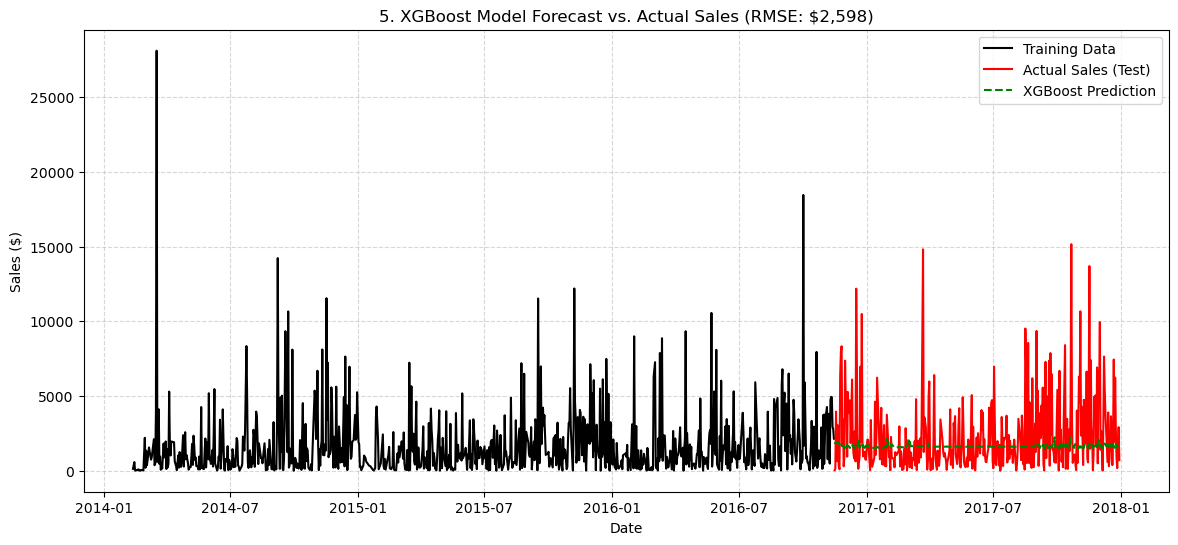

In [107]:
#  Plot Real and Forecast Sales
plt.figure(figsize=(14, 6))
# Plotting both train and test data
plt.plot(X_train.index, y_train, label='Training Data', color='black')
plt.plot(X_test.index, y_test, label='Actual Sales (Test)', color='red')
plt.plot(X_test.index, predictions_xgb, label='XGBoost Prediction', color='green', linestyle='--')
plt.title(f'5. XGBoost Model Forecast vs. Actual Sales (RMSE: ${xgb_rmse:,.0f})')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

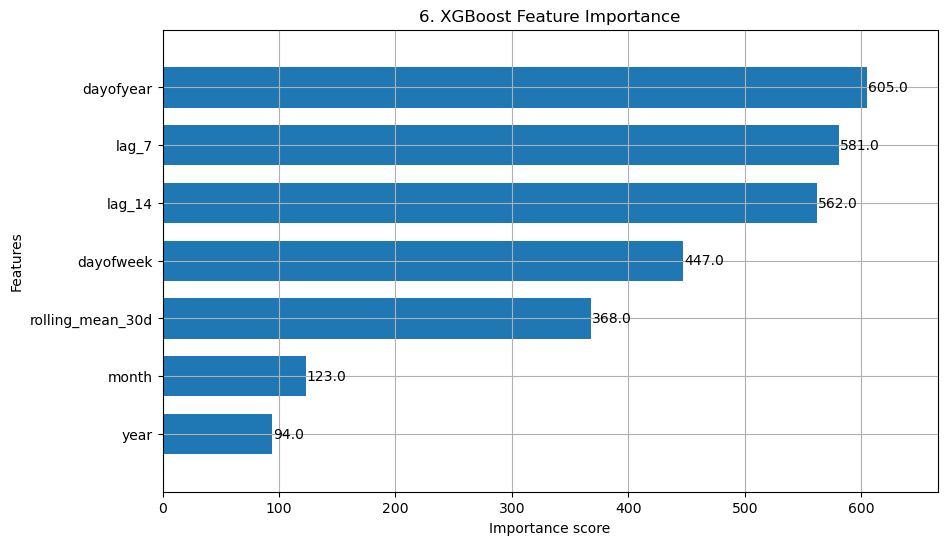

In [109]:
#  Feature Importance Plot
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(reg, ax=ax, height=0.7)
plt.title('6. XGBoost Feature Importance')
plt.show()

In [111]:
#Final Model Comparison

print("| Model | RMSE | MAE |")
print("| :--- | :--- | :--- |")
print(f"| Prophet | ${prophet_rmse:,.2f} | ${prophet_mae:,.2f} |")
print(f"| XGBoost | ${xgb_rmse:,.2f} | ${xgb_mae:,.2f} |")

| Model | RMSE | MAE |
| :--- | :--- | :--- |
| Prophet | $2,612.60 | $1,795.34 |
| XGBoost | $2,598.24 | $1,716.00 |
